In [59]:
#Imports
from mapie.metrics import regression_coverage_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample
from sklearn.model_selection import StratifiedKFold
from scripts import bookdatafunctions as bdf
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn import metrics
import random
from datasets import Dataset, DatasetDict
from itertools import chain, combinations
from tqdm import tqdm
import seaborn as sns
import matplotlib
import os
from natsort import natsorted
from scripts import corpusMLfunctions as cmf
from scipy.sparse import vstack
from sklearn.feature_selection import f_regression
from datasets import logging
import json
import shutil

In [60]:
#Constants
BASE_BEG = "SnippetDatasets/"
BASE_MID = "sniplen_"
BASE_END = ".jsonl"
KEYLIST_FILE = "Keylists.jsonl"
SNIPPET_LENS = ['5','10','25','50','75','100']
logging.set_verbosity(40)
KEYLIST_NUM = 0

In [61]:
keylists = []
with open(KEYLIST_FILE, 'r') as f:
    for line in f:
        keylists.append(json.loads(line))

In [62]:
#TFIDF Vectorizer functions
def do_nothing(ex):
    return ex.lower()

def conllu_tokenizer(ex):
    return ex.replace("\n", "\t").replace("|", "\t").split("\t")

def whitespace_tokenizer(ex):
    return ex.split(" ")

In [63]:
#Load keys
train_keys = keylists[KEYLIST_NUM]['train_keys']
eval_keys = keylists[KEYLIST_NUM]['eval_keys']
test_keys = keylists[KEYLIST_NUM]['test_keys']

In [64]:
#Local cache management for HF
#Also makes it easier to clean cache files and use space more efficiently
cache_dir = "cache_dir/temp/"
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
os.mkdir(cache_dir)
cache_file_trains = [cache_dir+str(KEYLIST_NUM)+"_"+str(SNIPPET_LENS[x])+"_train.jsonl" for x in range(6)]
cache_file_evals = [cache_dir+str(KEYLIST_NUM)+"_"+str(SNIPPET_LENS[x])+"_eval.jsonl" for x in range(6)]
cache_file_tests = [cache_dir+str(KEYLIST_NUM)+"_"+str(SNIPPET_LENS[x])+"_test.jsonl" for x in range(6)]
#Generate datasets
train_dss = [cmf.combineSnippedBooksToDS(train_keys, x, cache_dir, cache_file=cache_dir+str(KEYLIST_NUM)+"_"+x+"_train.jsonl", folder=BASE_BEG, inc_raw_text=True) for x in SNIPPET_LENS]
eval_dss = [cmf.combineSnippedBooksToDS(eval_keys, x, cache_dir, cache_file=cache_dir+str(KEYLIST_NUM)+"_"+x+"_eval.jsonl", folder=BASE_BEG, inc_raw_text=True) for x in SNIPPET_LENS]
test_dss = [cmf.combineSnippedBooksToDS(test_keys, x, cache_dir, cache_file=cache_dir+str(KEYLIST_NUM)+"_"+x+"_test.jsonl", folder=BASE_BEG, inc_raw_text=True) for x in SNIPPET_LENS]

Generating train split: 162834 examples [00:00, 1484138.48 examples/s]
Generating train split: 81449 examples [00:00, 832454.55 examples/s]
Generating train split: 32626 examples [00:00, 339458.09 examples/s]
Generating train split: 16352 examples [00:00, 179543.50 examples/s]
Generating train split: 10921 examples [00:00, 107260.43 examples/s]
Generating train split: 8217 examples [00:00, 93703.45 examples/s]
Generating train split: 37979 examples [00:00, 1451531.96 examples/s]
Generating train split: 18995 examples [00:00, 776147.89 examples/s]
Generating train split: 7607 examples [00:00, 409125.62 examples/s]
Generating train split: 3807 examples [00:00, 158199.57 examples/s]
Generating train split: 2540 examples [00:00, 131679.53 examples/s]
Generating train split: 1908 examples [00:00, 85768.68 examples/s]
Generating train split: 30222 examples [00:00, 1525596.11 examples/s]
Generating train split: 15122 examples [00:00, 853604.99 examples/s]
Generating train split: 6059 examples

In [65]:
from pprint import pprint
from collections import Counter


#"Equal" the number based on age groups
min_nums_train = []
min_nums_eval = []
min_nums_test = []

for i in range(6):
    min_nums_train.append(np.min(list(Counter(train_dss[i]['label']).values())))
    min_nums_eval.append(np.min(list(Counter(eval_dss[i]['label']).values())))
    min_nums_test.append(np.min(list(Counter(test_dss[i]['label']).values())))

for i in range(6):
    train_df = train_dss[i].to_pandas()
    sampled = pd.concat([train_df[train_df['label'] == '7-8'].sample(min_nums_train[i], replace=False), train_df[train_df['label'] == '9-12'].sample(min_nums_train[i], replace=False), train_df[train_df['label'] == '13+'].sample(min_nums_train[i], replace=False)])
    sampled = sampled[sampled['book_id'].apply(lambda x: x[-1] != '3')]
    train_dss[i] = Dataset.from_pandas(sampled).shuffle()
    eval_df = eval_dss[i].to_pandas()
    sampled = pd.concat([eval_df[eval_df['label'] == '7-8'].sample(min_nums_eval[i], replace=False), eval_df[eval_df['label'] == '9-12'].sample(min_nums_eval[i], replace=False), eval_df[eval_df['label'] == '13+'].sample(min_nums_eval[i], replace=False)])
    sampled = sampled[sampled['book_id'].apply(lambda x: x[-1] != '3')]
    eval_dss[i] = Dataset.from_pandas(sampled).shuffle()
    test_df = test_dss[i].to_pandas()
    sampled = pd.concat([test_df[test_df['label'] == '7-8'].sample(min_nums_test[i], replace=False), test_df[test_df['label'] == '9-12'].sample(min_nums_test[i], replace=False), test_df[test_df['label'] == '13+'].sample(min_nums_test[i], replace=False)])
    sampled = sampled[sampled['book_id'].apply(lambda x: x[-1] != '3')]
    test_dss[i] = Dataset.from_pandas(sampled).shuffle()


In [66]:
vectorizers = [TfidfVectorizer(norm='l2', tokenizer=whitespace_tokenizer, preprocessor=do_nothing, max_features=2000).fit(x['raw_text']) for x in train_dss]

/home/tenojo/miniconda3/envs/Test/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [126]:
#Choose vectorizer and dataset
SNIP_CHOS = 2

In [127]:
vectorized_training_data = vectorizers[SNIP_CHOS].transform(train_dss[SNIP_CHOS]['raw_text'])
vectorized_eval_data = vectorizers[SNIP_CHOS].transform(eval_dss[SNIP_CHOS]['raw_text'])
vectorized_test_data = vectorizers[SNIP_CHOS].transform(test_dss[SNIP_CHOS]['raw_text'])

### Brief adventure into clustering to see what's what

In [128]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto').fit_predict(vectorized_training_data)

In [135]:
from sklearn.decomposition import PCA
pca = PCA(5).fit(vectorized_training_data)
#Transform the data
df = pca.transform(vectorized_training_data)
pprint(pca.explained_variance_ratio_)

array([0.0860121 , 0.03484757, 0.02349792, 0.01596085, 0.01420723])


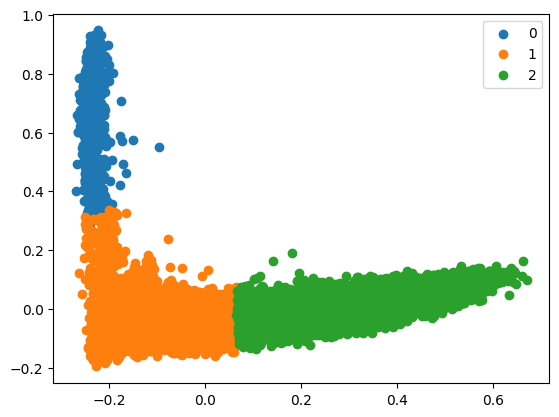

In [130]:
#Getting the Centroids
import matplotlib.pyplot as plt
 
#plotting the results:
 
#Getting unique labels
u_labels = np.unique(kmeans)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[kmeans == i , 0] , df[kmeans == i , 1] , label = i)
plt.legend()
plt.show()

In [72]:
pprint(kmeans)
pprint(train_dss[SNIP_CHOS]['label'])

array([1, 2, 2, ..., 1, 1, 1], dtype=int32)
['9-12',
 '9-12',
 '13+',
 '9-12',
 '7-8',
 '7-8',
 '13+',
 '9-12',
 '13+',
 '7-8',
 '9-12',
 '9-12',
 '7-8',
 '7-8',
 '7-8',
 '9-12',
 '13+',
 '7-8',
 '9-12',
 '13+',
 '13+',
 '13+',
 '9-12',
 '13+',
 '9-12',
 '13+',
 '7-8',
 '7-8',
 '9-12',
 '9-12',
 '9-12',
 '13+',
 '7-8',
 '9-12',
 '13+',
 '9-12',
 '13+',
 '7-8',
 '13+',
 '9-12',
 '9-12',
 '9-12',
 '7-8',
 '13+',
 '9-12',
 '13+',
 '13+',
 '13+',
 '9-12',
 '9-12',
 '7-8',
 '13+',
 '9-12',
 '13+',
 '9-12',
 '13+',
 '13+',
 '13+',
 '9-12',
 '7-8',
 '13+',
 '13+',
 '9-12',
 '7-8',
 '7-8',
 '13+',
 '9-12',
 '7-8',
 '13+',
 '7-8',
 '13+',
 '7-8',
 '7-8',
 '9-12',
 '13+',
 '13+',
 '13+',
 '13+',
 '13+',
 '7-8',
 '7-8',
 '7-8',
 '7-8',
 '13+',
 '13+',
 '7-8',
 '7-8',
 '9-12',
 '9-12',
 '13+',
 '9-12',
 '7-8',
 '13+',
 '13+',
 '9-12',
 '9-12',
 '13+',
 '9-12',
 '13+',
 '7-8',
 '13+',
 '13+',
 '7-8',
 '7-8',
 '9-12',
 '9-12',
 '13+',
 '13+',
 '7-8',
 '9-12',
 '13+',
 '7-8',
 '9-12',
 '7-8',
 '7-8',

### Regression

In [73]:
def transformToPen(x):
    return x**2
    if x >= -1 and x <= 1:
        return 0
    elif np.abs(x) < 2:
        return pow(x, 2)
    elif np.abs(x) < 3:
        return pow(np.abs(x)+0.25, 2)
    else:
        return pow(np.abs(x)+0.5, 2)
vecd_pen_func = np.vectorize(transformToPen)

In [74]:
def customRegressionScore(y_true, y_pred):
    #Customized penalty for guessing the age of a passage of text
    #If prediction within +-1, then it should be "correct"
    #If prediction is off by more than one year, then use slightly different penalties whether guess was under or over truth
    #If in range (-2, -1), linear penalty
    #If in range (+1, +1.5), linear penalty
    #If range is further, then apply squared penalty
    diff_matrix = np.array(y_true) - np.array(y_pred)
    if len(Counter(y_pred).keys()) < 10:
        return 100
    return np.mean(vecd_pen_func(diff_matrix))

In [75]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import normalize
import optuna

def objective(trial):
    #Defining hyperparameters to tune
    alpha = trial.suggest_float('alpha', 1e-5, 1e+0, log=True)
    tol = trial.suggest_float('tol', 1e-6, 1e-3, log=True)
    #l_ratio = trial.suggest_float('l_ratio', 0, 1)
    #r_state = trial.suggest_int('r_state', 0, 1000)

    mses = []
    for snip in range(5,6):
        lr_model = Lasso(
            alpha=alpha,
            tol=tol,
            random_state=42
        )
        vectorized_train_data = vectorizers[snip].transform(train_dss[snip]['raw_text'])
        vectorized_eval_data = vectorizers[snip].transform(eval_dss[snip]['raw_text'])
        lr_model.fit(vectorized_train_data, train_dss[snip]['age'])
        y_eval_pred = lr_model.predict(vectorized_eval_data)
        y_eval_true = eval_dss[snip]['age']
        mses.append(metrics.mean_squared_error(y_eval_true, y_eval_pred))
    return np.max(mses)

In [76]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-08-22 10:10:59,234] A new study created in memory with name: no-name-7dd75ef1-c48d-46c9-9f65-316f5d8823bf
[I 2025-08-22 10:11:00,695] Trial 0 finished with value: 10.023892597848395 and parameters: {'alpha': 0.10464375918717601, 'tol': 0.000856660655434053}. Best is trial 0 with value: 10.023892597848395.
[I 2025-08-22 10:11:02,102] Trial 1 finished with value: 10.300337450568014 and parameters: {'alpha': 0.0652226765137734, 'tol': 6.877906529231795e-05}. Best is trial 0 with value: 10.023892597848395.
[I 2025-08-22 10:11:04,628] Trial 2 finished with value: 9.051911428073392 and parameters: {'alpha': 0.00024315341716352163, 'tol': 2.1211549057285537e-06}. Best is trial 2 with value: 9.051911428073392.
[I 2025-08-22 10:11:06,017] Trial 3 finished with value: 9.73630065188597 and parameters: {'alpha': 0.7014103282187759, 'tol': 2.3565659934906583e-05}. Best is trial 2 with value: 9.051911428073392.
[I 2025-08-22 10:11:08,810] Trial 4 finished with value: 9.21358583205702 and par

In [77]:
# Print the best trial's hyperparameters and objective value
best_trial = study.best_trial
print(f"Best trial (number {best_trial.number}):")
print(f"  Value: {best_trial.value}")
print(f"  Params: {best_trial.params}")

Best trial (number 11):
  Value: 8.721617929087166
  Params: {'alpha': 0.002873438743221861, 'tol': 1.9186582649706355e-06}


In [78]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('MEDAE: ', round(np.sqrt(median_absolute_error),4))

In [79]:
from sklearn.metrics import PredictionErrorDisplay
true_pred_pairs = []
models = []
for snip in range(0,6):
    print("Results for sniplen ",SNIPPET_LENS[snip],":")
    lr_model = Lasso(
        alpha=study.best_params['alpha'],
        tol = study.best_params['tol'],
        random_state=42
    )
    vectorized_train_data = vectorizers[snip].transform(train_dss[snip]['raw_text'])
    vectorized_test_data = vectorizers[snip].transform(test_dss[snip]['raw_text'])
    lr_model.fit(vectorized_train_data, train_dss[snip]['age'])
    models.append(lr_model)
    y_pred = lr_model.predict(vectorized_test_data)
    y_true = test_dss[snip]['age']
    true_pred_pairs.append((y_true, y_pred))
    regression_results(y_true, y_pred)
    print('\n')


Results for sniplen  5 :
explained_variance:  0.1064
mean_squared_log_error:  0.0632
r2:  0.1005
MAE:  2.467
MSE:  8.0962
RMSE:  2.8454
MEDAE:  1.5448


Results for sniplen  10 :
explained_variance:  0.151
mean_squared_log_error:  0.0609
r2:  0.1446
MAE:  2.3686
MSE:  7.6922
RMSE:  2.7735
MEDAE:  1.4993


Results for sniplen  25 :
explained_variance:  0.1772
mean_squared_log_error:  0.0606
r2:  0.1677
MAE:  2.3006
MSE:  7.4748
RMSE:  2.734
MEDAE:  1.4518


Results for sniplen  50 :
explained_variance:  0.2046
mean_squared_log_error:  0.0603
r2:  0.1955
MAE:  2.2384
MSE:  7.254
RMSE:  2.6933
MEDAE:  1.4215


Results for sniplen  75 :
explained_variance:  0.2279
mean_squared_log_error:  0.06
r2:  0.2163
MAE:  2.1926
MSE:  7.1147
RMSE:  2.6673
MEDAE:  1.3934


Results for sniplen  100 :
explained_variance:  0.23
mean_squared_log_error:  0.0607
r2:  0.2208
MAE:  2.1843
MSE:  7.0808
RMSE:  2.661
MEDAE:  1.3972




### Plotting predicted vs actual values

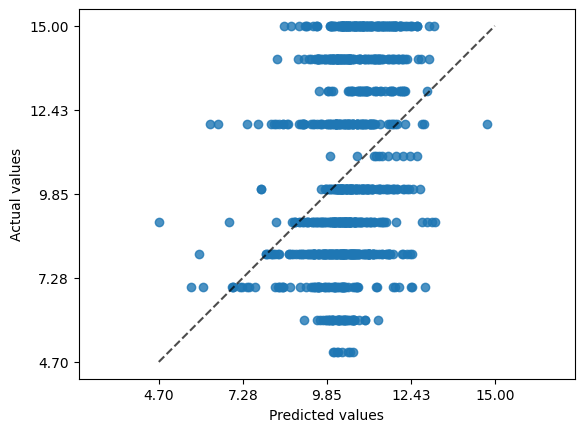

In [80]:
from matplotlib import pyplot as plt
import seaborn as sns

s=0

disp = PredictionErrorDisplay.from_predictions(true_pred_pairs[s][0], true_pred_pairs[s][1], kind='actual_vs_predicted')


#axes = sns.boxplot(x=true_pred_pairs[s][0], y=true_pred_pairs[s][1])
#axes.set_xticks(range(5,15))
#axes.set_yticks(range(4,18))



### Feature importance

In [81]:
from pprint import pprint

In [82]:
#Reverse the dictionary
index2features = {}
for i in range(len(SNIPPET_LENS)):
    index2feature = {}
    vectorizer = vectorizers[i]
    for feature,idx in vectorizer.vocabulary_.items():
        assert idx not in index2feature #This really should hold
        index2feature[idx]=feature
    index2features[i] = index2feature
#Now we can query index2feature to get the feature names as we need

In [83]:
highest_prios = {}
for i in range(6):
    model = models[i]
    # make a list of (weight, index), sort it
    lst=[]
    for idx,weight in enumerate(model.coef_):
        lst.append((weight,idx))
    lst.sort() #sort

    #Print first few and last few
    #for weight,idx in lst[:20]: #first 30 (ie lowest weight)
    #    print(index2feature[idx])
    #print("----------------------------------------------------")
    #Take the last 30 (lst[-30:]) but these now come from weakest to strongest
    #so reverse the list using [::-1]
    highest_prio = []
    for weight,idx in lst[-20:][::-1]:
        highest_prio.append(index2features[i][idx])
    highest_prios[i] = highest_prio

In [84]:
pprint(highest_prios)

{0: ['mä',
     'juuli',
     '"',
     'en',
     'hänen',
     'mun',
     '.',
     'olen',
     'olin',
     'minua',
     'kuin',
     'ollut',
     'että',
     'mua',
     'sä',
     'minut',
     'ei',
     'on',
     'olisi',
     'minulle'],
 1: ['juuli',
     'en',
     'mä',
     'hänen',
     '"',
     '.',
     'mun',
     'olen',
     'olin',
     'ollut',
     'you',
     'minulle',
     'että',
     'kuin',
     'minut',
     'katsoo',
     'minua',
     'olisi',
     'mua',
     'ei'],
 2: ['juuli',
     'en',
     'hänen',
     'olen',
     'ollut',
     'mä',
     '.',
     'mun',
     '"',
     'olin',
     'minulle',
     'on',
     'minut',
     'katsoo',
     'kuin',
     'olisi',
     'että',
     'ei',
     'sä',
     'mua'],
 3: ['juuli',
     'hänen',
     'en',
     'ollut',
     'olen',
     'mä',
     'tiny',
     'ei',
     '"',
     '.',
     'olin',
     'mun',
     'on',
     'katsoo',
     'kuin',
     'että',
     'olisi',
     'minut',
     'sä',
 

### Clean up cache files

In [85]:
"""
for x in cache_file_trains:
    os.remove(x)
for x in cache_file_evals:
    os.remove(x)
for x in cache_file_tests:
    os.remove(x)
"""

'\nfor x in cache_file_trains:\n    os.remove(x)\nfor x in cache_file_evals:\n    os.remove(x)\nfor x in cache_file_tests:\n    os.remove(x)\n'